In [42]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.spatial import distance
from scipy.io import loadmat

## 2 Image Features

### 2.2 Robustness of Keypoint Detector


In [43]:
# Read image
img = cv.imread('obj1_5.JPG')
# Create SIFT and SURF objects
sift = cv.xfeatures2d.SIFT_create(contrastThreshold=0.18, edgeThreshold=5)
surf = cv.xfeatures2d.SURF_create(400)
surf.setHessianThreshold(8000)

In [52]:
# SIFT
kp = sift.detect(img, None)
img_sift = cv.drawKeypoints(img, kp, None, (0, 255, 0), 0)
cv.imwrite('sift_keypoints.jpg', img_sift)

# SURF
kp = surf.detect(img, None)
img_surf = cv.drawKeypoints(img, kp, None, (0, 255, 0), 0)
cv.imwrite('surf_keypoints.jpg', img_surf)

True

In [44]:
def rpt_cal(kp_ideal, kp_m):
    # Repeatability Calculation
    # Find the best-matched key points corresponds with the requirements of 'match point'
    num_match = 0
    # match_flag = 0
    kp_m_label = np.zeros(kp_m.shape[1])

    for j in range(kp_ideal.shape[1]):
        mindist = 1000000000
        best_match = -1
        for k in range(kp_m.shape[1]):
            if np.abs(kp_ideal[0, j] - kp_m[0, k]) <= 2 and \
                    np.abs(kp_ideal[1, j] - kp_m[1, k]) <= 2 and \
                    kp_m_label[k] == 0:
                # match_flag = 1
                dist = (kp_ideal[0, j] - kp_m[0, k])**2 + (kp_ideal[1, j] - kp_m[1, k])**2
                if dist <= mindist:
                    mindist = dist
                    best_match = k
                # best_match = k
        if best_match != -1:
            kp_m_label[best_match] = 1
            num_match += 1
        # match_flag = 0

    rept = num_match / kp_ideal.shape[1]

    return rept


#### 2.2.1 Repeatability vs. Rotation Angle

In [45]:
def image_rotate_kp(img, angle, sift=sift, surf=surf, flag=1):

    img_rot = ndimage.rotate(img, angle, reshape=True)

    if flag:
        # Detect key points in the original image
        kp = sift.detect(img, None)
        kp_rot = sift.detect(img_rot, None)

    else:
        kp = surf.detect(img, None)
        kp_rot = surf.detect(img_rot, None)

    kp = np.array([[k.pt[0], k.pt[1]] for k in kp])
    kp_rot = np.array([[k.pt[0], k.pt[1]] for k in kp_rot])
    kp_rot = kp_rot.T

    # Calculate the coordinates of key points in original image after aligning with the modified image
    kp_ideal = np.copy(kp)
    kp_ideal -= np.array([img.shape[1] / 2, img.shape[0] / 2]).reshape(1, -1)
    R = np.array([[np.cos(-angle * np.pi / 180), -np.sin(-angle * np.pi / 180)], [np.sin(-angle * np.pi / 180), np.cos(-angle * np.pi / 180)]])
    kp_ideal = np.dot(R, kp_ideal.T) + np.array([img_rot.shape[1] / 2, img_rot.shape[0] / 2]).reshape(-1, 1)

    return kp_ideal, kp_rot   # (2, # of kp)


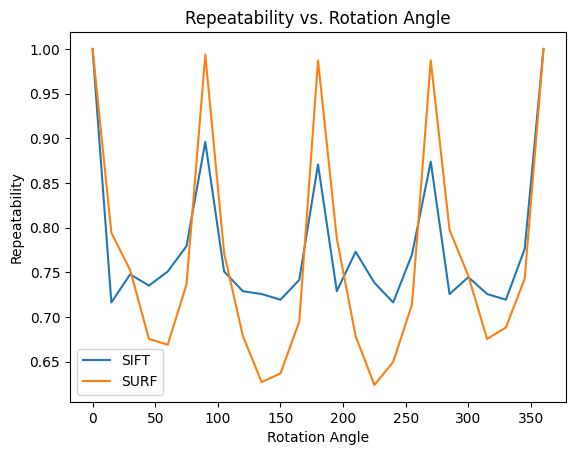

In [46]:
view_angle = np.linspace(0, 360, 25)
rept_sift = np.zeros(view_angle.size)
rept_surf = np.zeros(view_angle.size)

for i in range(view_angle.size):
    angle = view_angle[i]

    kp_ideal, kp_rot = image_rotate_kp(img, angle, sift=sift, surf=surf, flag=1)
    rept_sift[i] = rpt_cal(kp_ideal, kp_rot)
    kp_ideal, kp_rot = image_rotate_kp(img, angle, sift=sift, surf=surf, flag=0)
    rept_surf[i] = rpt_cal(kp_ideal, kp_rot)

plt.figure()
plt.plot(view_angle, rept_sift)
plt.plot(view_angle, rept_surf)
plt.legend(['SIFT', 'SURF'])
plt.xlabel('Rotation Angle')
plt.ylabel('Repeatability')
plt.title('Repeatability vs. Rotation Angle')
plt.savefig('Repeatability_vs_Rotation.jpg')
plt.show()

#### 2.2.2 Repeatability vs. Scaling Factor

In [54]:
def image_scale_kp(img, factor):
    ### In OpenCV, SURF cannot keep the number of keypoints constant after scaling, which will affect the repeatability of the detector. Therefore, we use MATLAB to obtain the keypoints instead.

    img_scal = cv.resize(img, (int(img.shape[1]*factor), int(img.shape[0]*factor)))

    # Create SIFT object with a constant number of features (keypoints)
    sift = cv.xfeatures2d.SIFT_create(nfeatures=317, contrastThreshold=0.09, edgeThreshold=5)
    # Detect key points in the original image
    kp = sift.detect(img, None)
    kp_scal = sift.detect(img_scal, None)

    kp = np.array([[k.pt[0], k.pt[1]] for k in kp])
    kp_scal = np.array([[k.pt[0], k.pt[1]] for k in kp_scal])
    kp_scal = kp_scal.T

    # Calculate the coordinates of key points in original image after aligning with the modified image
    kp_ideal = np.copy(kp).T
    kp_ideal = kp_ideal * factor

    return kp_ideal, kp_scal

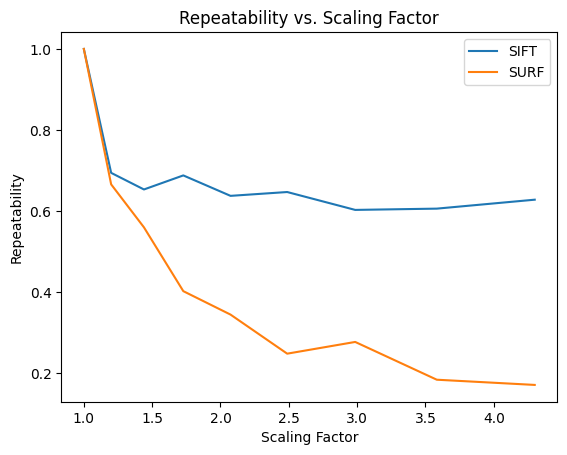

In [57]:
########Scale the image and calculate repeatability########
scale_factor = 1.2 ** np.linspace(0, 8, 9)
rept_sift = np.zeros(scale_factor.size)
rept_surf = np.zeros(scale_factor.size)

# Load SURF keypoints obtained in MATLAB
kp_mat = loadmat(r'kp_scal_surf.mat')
kp_surf = np.zeros(kp_mat['kp_surf'].shape)
for i in range(kp_mat['kp_surf'].shape[0]):
    for j in range(kp_mat['kp_surf'].shape[1]):
        for k in range(kp_mat['kp_surf'].shape[2]):
            kp_surf[i][j][k] = kp_mat['kp_surf'][i][j][k]
kp_ori_surf = kp_surf[-1]

# Calculate repeatability
for i in range(scale_factor.size):

    factor = scale_factor[i]
    kp_ideal, kp_scal = image_scale_kp(img, factor)
    rept_sift[i] = rpt_cal(kp_ideal, kp_scal)
    kp_ideal_surf = kp_ori_surf * factor
    rept_surf[i] = rpt_cal(kp_ideal_surf, kp_surf[i])

plt.figure()
plt.plot(scale_factor, rept_sift)
plt.plot(scale_factor, rept_surf)
plt.legend(['SIFT', 'SURF'])
plt.xlabel('Scaling Factor')
plt.ylabel('Repeatability')
plt.title('Repeatability vs. Scaling Factor')
plt.savefig('Repeatability_vs_Scaling.jpg')
plt.show()

## 3 Image Feature Matching

### 3.1 SIFT Features Extraction

In [58]:
# Import images
img1 = cv.imread('obj1_5.JPG')   # query image
img2 = cv.imread('obj1_t1.JPG')  # database image
# Creat sift object
sift = cv.xfeatures2d.SIFT_create(contrastThreshold=0.18, edgeThreshold=5)
# Extract SIFT descriptors
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)
# Save images with key points superimposed
img1_sift = cv.drawKeypoints(img1, kp1, None, (0, 255, 0), 0)
#cv.imwrite('3_a_sift_des_5.jpg', img1_sift)
img2_sift = cv.drawKeypoints(img2, kp2, None, (0, 255, 0), 0)
#cv.imwrite('3_a_sift_des_t1.jpg', img2_sift)

### 3.2 Fixed Threshold Matching Algorithm

In [59]:
# Set the threshold
thr = 205
# Select the matches with distance within the threshold
matches = []

for i in range(des1.shape[0]):
    for j in range(des2.shape[0]):
        if distance.euclidean(des1[i, :], des2[j, :]) <= thr:
            matches.append([i, j])

matches = np.array(matches)

# Draw lines that connect matched key points on side-by-side image
img_1_2 = cv.hconcat([img1, img2])
kp1_cor = np.array([[k.pt[0], k.pt[1]] for k in kp1], dtype='float32')  # (# of kp, 2)
kp2_cor = np.array([[k.pt[0], k.pt[1]] for k in kp2], dtype='float32')  # (# of kp, 2)
kp2_cor += np.array([img1.shape[1], 0]).reshape(1, -1)                  # (# of kp, 2)
for i in range(matches.shape[0]):
    cv.line(img_1_2, tuple(kp1_cor[matches[i, 0], :]), tuple(kp2_cor[matches[i, 1], :]), color=(255, 0, 0), thickness=3)
#cv.imwrite('3_b_fixed_threshold_{}.jpg'.format(thr), img_1_2)

### 3.3 Nearest Neighbor Matching Algorithm

In [60]:
# Set the threshold
thr = 208
# Create Brute-force Matcher object
bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
# Match descriptors
matches = bf.match(des1, des2)
# Sort them in the order of their distance
matches = sorted(matches, key=lambda x: x.distance)
# Select the matches with distance within the threshold
match_dis = np.array([k.distance for k in matches])
number_match = 0
for i in range(match_dis.size):
    if match_dis[i] < thr:
        number_match += 1
    else:
        break

# Draw lines that connect matched key points on side-by-side image
img_1_2 = cv.hconcat([img1, img2])
kp1_cor = np.array([[k.pt[0], k.pt[1]] for k in kp1], dtype='float32')  # (# of kp, 2)
kp2_cor = np.array([[k.pt[0], k.pt[1]] for k in kp2], dtype='float32')  # (# of kp, 2)
kp2_cor += np.array([img1.shape[1], 0]).reshape(1, -1)                  # (# of kp, 2)
for i in range(len(matches[:number_match])):
    cv.line(img_1_2, tuple(kp1_cor[matches[i].queryIdx, :]), tuple(kp2_cor[matches[i].trainIdx, :]), color=(255, 0, 0), thickness=3)
#cv.imwrite('3_c_nearest_nbr_{}.jpg'.format(thr), img_1_2)
#img_match = cv.drawMatches(img1, kp1, img2, kp2, matches[:number_match], None, flags=2)
#cv.imwrite('3_c_nearest_nbr_1.jpg', img_match)

### 3.4 Nearest Neighbor Distance Ratio Algorithm

In [61]:
# Import images
img1 = cv.imread('obj1_5.JPG')   # query image
img2 = cv.imread('obj1_t1.JPG')  # database image
# Creat sift object
sift = cv.xfeatures2d.SIFT_create(contrastThreshold=0.18, edgeThreshold=5)
# Extract SIFT descriptors
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)
# Save images with key points superimposed
img1_sift = cv.drawKeypoints(img1, kp1, None, (0, 255, 0), 0)
#cv.imwrite('3_a_sift_des_5.jpg', img1_sift)
img2_sift = cv.drawKeypoints(img2, kp2, None, (0, 255, 0), 0)
#cv.imwrite('3_a_sift_des_t1.jpg', img2_sift)
# Set the threshold
thr = 0.72
# Create Brute-force Matcher object
bf = cv.BFMatcher()
# Match descriptors
matches = bf.knnMatch(des1, des2, k=2)
good = []

for m, n in matches:
    if m.distance < thr * n.distance:
        good.append(m)

good = np.array(good)

# Draw lines that connect matched key points on side-by-side image
img_1_2 = cv.hconcat([img1, img2])
kp1_cor = np.array([[k.pt[0], k.pt[1]] for k in kp1], dtype='float32')  # (# of kp, 2)
kp2_cor = np.array([[k.pt[0], k.pt[1]] for k in kp2], dtype='float32')  # (# of kp, 2)
kp2_cor += np.array([img1.shape[1], 0]).reshape(1, -1)                  # (# of kp, 2)
for i in range(len(good)):
    cv.line(img_1_2, tuple(kp1_cor[good[i].queryIdx, :]), tuple(kp2_cor[good[i].trainIdx, :]), color=(255, 0, 0), thickness=3)
#cv.imwrite('3_d_nearest_ndr_{}.jpg'.format(thr), img_1_2)
#img_match = cv.drawMatchesKnn(img1, kp1, img2, kp2, good, None, flags=2)
#cv.imwrite('nearest_ndr.jpg', img_match)

### 3.5 SURF-NNDR

In [62]:
# Import images
img1 = cv.imread('obj1_5.JPG')   # query image
img2 = cv.imread('obj1_t1.JPG')  # database image
# Creat sift object
sift = cv.xfeatures2d.SIFT_create(contrastThreshold=0.18, edgeThreshold=5)
# Extract SIFT descriptors
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)
# Save images with key points superimposed
img1_sift = cv.drawKeypoints(img1, kp1, None, (0, 255, 0), 0)
#cv.imwrite('3_a_sift_des_5.jpg', img1_sift)
img2_sift = cv.drawKeypoints(img2, kp2, None, (0, 255, 0), 0)
#cv.imwrite('3_a_sift_des_t1.jpg', img2_sift)
# SURF Features Extraction
surf = cv.xfeatures2d.SURF_create(400)
surf.setHessianThreshold(8000)
kp1, des1 = surf.detectAndCompute(img1, None)
kp2, des2 = surf.detectAndCompute(img2, None)

# NNDR Implementation
thr = 0.70
# Create Brute-force Matcher object
bf = cv.BFMatcher()
# Match descriptors
matches = bf.knnMatch(des1, des2, k=2)
good = []

for m, n in matches:
    if m.distance < thr * n.distance:
        good.append(m)

good = np.array(good)

# Draw lines that connect matched key points on side-by-side image
img_1_2 = cv.hconcat([img1, img2])
kp1_cor = np.array([[k.pt[0], k.pt[1]] for k in kp1], dtype='float32')  # (# of kp, 2)
kp2_cor = np.array([[k.pt[0], k.pt[1]] for k in kp2], dtype='float32')  # (# of kp, 2)
kp2_cor += np.array([img1.shape[1], 0]).reshape(1, -1)                  # (# of kp, 2)
for i in range(len(good)):
    cv.line(img_1_2, tuple(kp1_cor[good[i].queryIdx, :]), tuple(kp2_cor[good[i].trainIdx, :]), color=(255, 0, 0), thickness=3)
#cv.imwrite('3_e_nearest_ndr_surf_{}.jpg'.format(thr), img_1_2)
#cv.imwrite('3_e_nearest_ndr_surf.jpg', img_1_2)
#img_match = cv.drawMatchesKnn(img1, kp1, img2, kp2, good, None, flags=2)
#cv.imwrite('nearest_ndr_surf.jpg', img_match)